# Critical exponents from finite-size scaling analysis

In [32]:
from matplotlib import pyplot as plt
import numpy as np
import glob
import re

Tc = 1/0.693035

save = True

folder = datafolder = "outputs"

files = glob.glob(folder + "/magnetization_L*" + ".txt")
Ls = []
for file in files:
    L = re.search("[0-9]+", file).group(0)
    Ls.append(L)

print(Ls)

def jackKnife(procedure, x, n):
    block_size = int(np.ceil(len(x) / n))
    f = []
    for i in range(n):
        start = int(i*block_size)
        end = int(min((i+1)*block_size, len(x)-1))
        x_loo = np.concatenate([x[:start], x[end:]])
        f.append(procedure(x_loo))

    f_bar = procedure(x)
    f = np.array(f)

    delta = np.sqrt((n-1)/n * np.sum((f-f_bar)**2))
    estimate = n * f_bar - (n-1) * np.mean(f)
    return estimate, delta


def sort(array, col):
    return array[array[:, col].argsort()]


num_Ls = len(Ls)
Ls = np.sort([int(Ls[i]) for i in range(len(Ls))])
color_id = np.linspace(0.3, 1, num_Ls)

mag_L = dict()
en_L = dict()
sus_L = dict()
cv_L = dict()

for i, L in enumerate(Ls):
    cid = color_id[i]

    mag_data = np.loadtxt(datafolder + "/magnetization_L"+str(L)+".txt")
    en_data = np.loadtxt(datafolder + "/energies_L"+str(L)+".txt")
    betas = mag_data[:, 0]
    sus = []
    mag = []
    en = []
    cv = []

    for id, beta in enumerate(betas):
        M = np.abs(mag_data[id, 1:]) / L**3
        E = en_data[id, 1:] / L**3

        def energy(e):
            return e.mean() 

        def magnetization(m):
            return m.mean()

        def specific_heat(e):
            e2 = (e**2).mean()
            e = e.mean()
            return beta**2*(e2-e**2) * L**3

        def susceptibility(m):
            m2 = (m**2).mean()
            m = m.mean()
            return beta*(m2-m**2) * L**3

        sus_val, sus_err = jackKnife(susceptibility, M, 20)
        sus.append([beta, sus_val, sus_err, plt.cm.PuBu(cid)])

        cv_val, cv_err = jackKnife(specific_heat, E, 20)
        cv.append([beta, cv_val, cv_err, plt.cm.PuBu(cid)])

        mag_val, mag_err = jackKnife(magnetization, M, 20)
        mag.append([beta, mag_val, mag_err, plt.cm.PuBu(cid)])

        en_val, en_err = jackKnife(energy, E, 20)
        en.append([beta, en_val, en_err, plt.cm.PuBu(cid)])

    sus_L[L] = sort(np.array(sus, dtype=np.ndarray), 0)
    cv_L[L] = sort(np.array(cv, dtype=np.ndarray), 0)
    mag_L[L] = sort(np.array(mag, dtype=np.ndarray), 0) 
    en_L[L] = sort(np.array(en, dtype=np.ndarray), 0)


['12', '10', '16', '8', '4', '32', '24', '20']


## Magnetisation
Let $\tau:=\frac{T-T_c}{T_c}$. For a finite system, the correlation length $\xi$ approaches the linear system size $L$ at criticality. Therefore, we use the finite-size scaling ansatz near the critical point for magnetisation $m\sim |\tau|^{\beta}$.
$$
m(T,L) \sim L^{\frac{-\beta}{\nu}} \mathcal{F}_m\left(\tau L^{\frac{1}{\nu}} \right).
$$

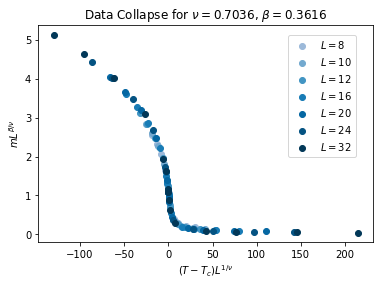

In [33]:
nu = 0.7036
beta = 0.3616

colors = {32: "black", 24: "magenta", 20: "cyan", 16: "yellow",
          12: "purple", 10: "blue", 8: "red", 4: "green"}

fig, ax = plt.subplots(1, figsize=(6, 4), sharex=True)

for L in Ls[1:]:
    tau_sc = (1/mag_L[L][:, 0] - Tc) * L ** (1/nu)
    mag_sc = mag_L[L][:, 1] * L ** (beta/nu)
    color = mag_L[L][0, -1]
    ax.plot(tau_sc, mag_sc, 'o', c=color, alpha=1, label=r"$L=$"+str(L))

ax.set_title(
    fr"Data Collapse for $\nu = ${nu:.4f}, $\beta = ${beta:.4f}")
ax.set_ylabel(r'$m L^{\beta/\nu}$')
ax.set_xlabel(r'$(T-T_c)L^{1/\nu}$')
fig.legend(loc=[0.75, 0.45])

if save:
    plt.savefig('outputs/mag_exponents.pdf', format='pdf', bbox_inches="tight")
if not save:
    plt.show()


## Susceptibility
For susceptibility, we have $\chi \sim |\tau|^{-\gamma}$:
$$
\chi(T,L) \sim L^{\frac{\gamma}{\nu}} \mathcal{F}_\chi\left(\tau L^{\frac{1}{\nu}} \right).
$$

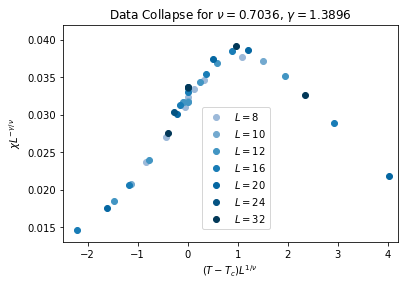

In [34]:
nu = 0.7036
gamma = 1.3896

colors = {32: "black", 24: "magenta", 20: "cyan", 16: "yellow", 12: "purple", 10: "blue", 8: "red", 4: "green"}

fig, ax = plt.subplots(1, figsize=(6, 4), sharex=True)

for L in Ls[1:]:
    tau_sc = (1/sus_L[L][:, 0] - Tc) * L ** (1/nu)
    sus_sc = sus_L[L][:, 1] * L ** (-gamma/nu)
    color = sus_L[L][0, -1]
    ax.plot(tau_sc, sus_sc, 'o', c=color, alpha=1, label=r"$L=$"+str(L))

ax.set_title(
    fr"Data Collapse for $\nu = ${nu:.4f}, $\gamma = ${gamma:.4f}")
ax.set_ylabel(r'$\chi L^{-\gamma/\nu}$')
ax.set_xlabel(r'$(T-T_c)L^{1/\nu}$')
ax.set_xlim([-2.5, 4.2])
ax.set_ylim([0.013, 0.042])
fig.legend(loc=[0.5,0.2])

if save:
    plt.savefig('outputs/chi_exponents.pdf', format='pdf', bbox_inches="tight")
if not save:
    plt.show()


## Specific heat
We have $c_V \sim |\tau|^{-\alpha}$. On the other hand, fitting the exponent with the previous method requires knowing the regular (i.e., non-diverging) background contribution to the specific heat:
$$
c_V(T,L) \sim c_{\rm regular}(\tau) + L^{\frac{\alpha}{\nu}} \mathcal{F}_{c_V}\left(\tau L^{\frac{1}{\nu}} \right).
$$

Alternatively, we can just use the susceptibility (or order parameter) and the correlation length exponents ($\gamma\approx 1.3696 (\beta\approx 0.3616), \nu=0.7036$) to determine the other four exponetns by the scaling laws:
$$\begin{align*}
\gamma &= \nu(2-\eta), \\
\alpha+2\beta+\gamma &= 2, \\
\gamma &= \beta(\delta-1), \\
\nu d &= 2-\alpha.
\end{align*}$$

This gives: 
$$\begin{align*}
\alpha &= 2- 3\nu \approx -0.1108, \\
\beta &= \frac{1}{2}(2-\alpha-\gamma)\approx 0.3606, \\
\eta &= 2 - \frac{\gamma}{\nu} \approx 0.0250, \\
\delta &= \frac{\gamma}{\beta} + 1 \approx 4.8429.
\end{align*}$$